# 01: Data Creation Using k-Wave Acoustic Simulation

This notebook generates training data for acoustic-based maze navigation.

## Process Overview

1. **Generate a maze** using `MazeGenerator`
2. **For each walkable position:**
   - Run k-Wave acoustic simulation to get sound signature
   - Query A* Oracle to get optimal action
   - Store (spectrogram, action) pair
3. **Save dataset** to HDF5 for efficient loading

## ⚠️ Important Notes

- **k-Wave simulations are computationally expensive** because they solve PDEs at each timestep
- **Use small mazes** (e.g., 20×20) for initial testing
- **This process can take hours** for larger mazes
- Consider running on HPC resources for production datasets

In [1]:
# Add src to path
import sys
sys.path.append('../')

import numpy as np
import h5py
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from src.simulation import AcousticSimulator
from src.environment import MazeGenerator, Oracle, Action
from src.utils import plot_maze, plot_multi_channel_spectrogram

## 1. Configuration

Set parameters for maze generation and acoustic simulation.

In [2]:
# Maze Configuration
MAZE_WIDTH = 20
MAZE_HEIGHT = 20
RANDOM_SEED = 42

# Acoustic Simulation Parameters
GRID_SPACING = 0.01  # 1 cm
SIMULATION_DURATION = 0.015  # 15 ms (keep short for speed)
SOURCE_FREQUENCY = 5000.0  # 5 kHz
NUM_MICROPHONES = 8

# Data Generation
OUTPUT_FILE = '../data/acoustic_navigation_data.h5'
MAX_SAMPLES = 5  # Set to integer to limit samples for testing

print(f"Configuration:")
print(f"  Maze: {MAZE_WIDTH}×{MAZE_HEIGHT}")
print(f"  Simulation: {SIMULATION_DURATION*1000:.1f} ms")
print(f"  Microphones: {NUM_MICROPHONES}")

Configuration:
  Maze: 20×20
  Simulation: 15.0 ms
  Microphones: 8


## 2. Generate Maze

Create the maze environment where the agent will navigate.

Maze shape: (20, 20)
Wall percentage: 45.5%


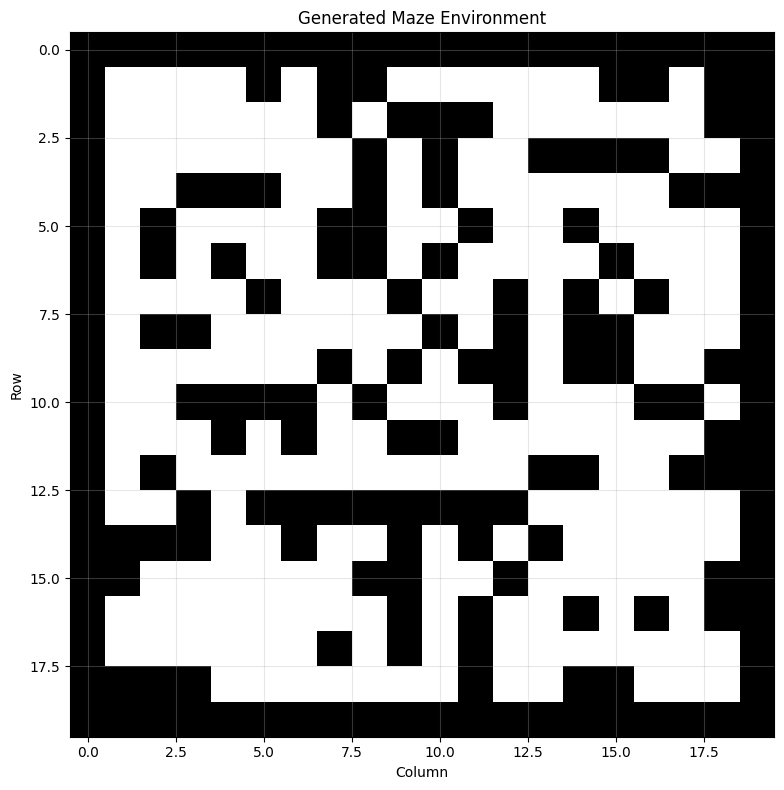

In [3]:
# Initialize maze generator
maze_gen = MazeGenerator(MAZE_WIDTH, MAZE_HEIGHT, random_seed=RANDOM_SEED)

# Generate maze (choose one method)
# Option 1: Simple random maze
maze = maze_gen.generate_simple_maze(wall_probability=0.3)

# Option 2: DFS-generated perfect maze
# maze = maze_gen.generate_dfs_maze()

# Option 3: Rooms and corridors
# maze = maze_gen.generate_rooms_and_corridors(num_rooms=4)

print(f"Maze shape: {maze.shape}")
print(f"Wall percentage: {100 * np.mean(maze):.1f}%")

# Visualize maze
fig = plot_maze(maze, title="Generated Maze Environment")
plt.show()

## 3. Initialize Simulator and Oracle

Set up the acoustic simulator (k-Wave) and navigation oracle (A*).

Goal position: (np.int64(1), np.int64(3))
Source position: (np.int64(6), np.int64(9))


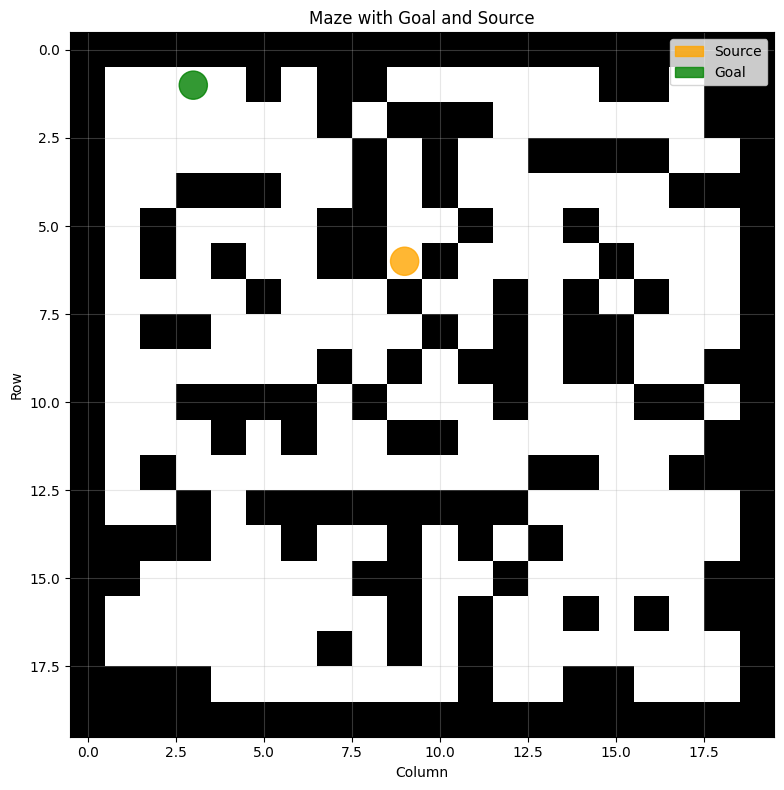

In [4]:
# Initialize acoustic simulator
simulator = AcousticSimulator(
    grid_spacing=GRID_SPACING,
    simulation_duration=SIMULATION_DURATION,
    source_frequency=SOURCE_FREQUENCY,
    num_microphones=NUM_MICROPHONES,
    pml_size=10,
)

# Initialize oracle
oracle = Oracle(maze)

# Get goal position (random walkable cell)
goal_pos = maze_gen.get_random_walkable_position(maze)
print(f"Goal position: {goal_pos}")

# Get sound source position (fixed for all simulations)
source_pos = maze_gen.get_random_walkable_position(maze)
print(f"Source position: {source_pos}")

# Visualize maze with goal and source
fig = plot_maze(
    maze,
    goal_pos=goal_pos,
    source_pos=source_pos,
    title="Maze with Goal and Source"
)
plt.show()

## 4. Test Single Simulation

Run a single k-Wave simulation to verify everything works.

In [5]:
# Get a random agent position
test_agent_pos = maze_gen.get_random_walkable_position(maze)
print(f"Test agent position: {test_agent_pos}")

# Run simulation
print("\nRunning k-Wave simulation...")
print("⚠️ This may take 30-60 seconds due to PDE solving")

sensor_data = simulator.run_simulation(
    maze=maze,
    agent_pos=test_agent_pos,
    source_pos=source_pos,
    verbose=True  # Show progress for this test
)

print(f"\nSensor data shape: {sensor_data.shape}")
print(f"  {sensor_data.shape[0]} microphones")
print(f"  {sensor_data.shape[1]} time steps")

# Compute spectrogram
spectrogram = simulator.compute_spectrogram(sensor_data)
print(f"\nSpectrogram shape: {spectrogram.shape}")
print(f"  {spectrogram.shape[0]} microphones")
print(f"  {spectrogram.shape[1]} frequency bins")
print(f"  {spectrogram.shape[2]} time bins")

# Get optimal action from oracle
optimal_action = oracle.get_optimal_action(test_agent_pos, goal_pos)
action_names = ['STOP', 'UP', 'DOWN', 'LEFT', 'RIGHT']
print(f"\nOptimal action: {action_names[optimal_action]}")

# Visualize
fig = plot_maze(
    maze,
    agent_pos=test_agent_pos,
    goal_pos=goal_pos,
    source_pos=source_pos,
    title=f"Test Configuration (Optimal: {action_names[optimal_action]})"
)
plt.show()

# Visualize spectrogram
fig = plot_multi_channel_spectrogram(
    spectrogram,
    title="Test Spectrogram (All Microphones)"
)
plt.show()

Test agent position: (np.int64(10), np.int64(9))

Running k-Wave simulation...
⚠️ This may take 30-60 seconds due to PDE solving


AttributeError: 'dict' object has no attribute 'is_gpu_simulation'

## 5. Generate Complete Dataset

Loop through all walkable positions and generate training data.

⚠️ **WARNING: This is computationally intensive!**

For a 20×20 maze with ~250 walkable cells:
- Each simulation: ~30-60 seconds
- Total time: **2-4 hours**

For larger mazes:
- 50×50 maze (~1500 cells): **12-25 hours**
- Consider using parallel processing or HPC

In [ ]:
# Get all walkable positions
walkable_positions = maze_gen.get_all_walkable_positions(maze)
print(f"Total walkable positions: {len(walkable_positions)}")

# Limit samples for testing if specified
if MAX_SAMPLES is not None:
    walkable_positions = walkable_positions[:MAX_SAMPLES]
    print(f"Limited to {len(walkable_positions)} samples for testing")

# Filter positions that have valid paths to goal
valid_positions = []
for pos in tqdm(walkable_positions, desc="Filtering reachable positions"):
    if oracle.is_reachable(pos, goal_pos):
        valid_positions.append(pos)

print(f"Reachable positions: {len(valid_positions)}")

# Prepare data storage
spectrograms_list = []
actions_list = []
positions_list = []

# Generate data
print("\n" + "="*50)
print("Starting data generation...")
print(f"Estimated time: {len(valid_positions) * 0.5 / 60:.1f} - {len(valid_positions) / 60:.1f} hours")
print("="*50 + "\n")

for idx, agent_pos in enumerate(tqdm(valid_positions, desc="Generating data")):
    try:
        # Run k-Wave simulation (verbose=False to avoid spam)
        sensor_data = simulator.run_simulation(
            maze=maze,
            agent_pos=agent_pos,
            source_pos=source_pos,
            verbose=False  # Keep quiet during batch processing
        )
        
        # Compute spectrogram
        spectrogram = simulator.compute_spectrogram(sensor_data)
        
        # Get optimal action
        optimal_action = oracle.get_optimal_action(agent_pos, goal_pos)
        
        # Store
        spectrograms_list.append(spectrogram)
        actions_list.append(optimal_action)
        positions_list.append(agent_pos)
        
    except Exception as e:
        print(f"\nError at position {agent_pos}: {e}")
        continue

print(f"\n✓ Generated {len(spectrograms_list)} samples")

## 6. Save Dataset to HDF5

Store the generated data in an efficient HDF5 format for training.

In [ ]:
# Convert lists to arrays
spectrograms_array = np.stack(spectrograms_list, axis=0)
actions_array = np.array(actions_list, dtype=np.int32)
positions_array = np.array(positions_list, dtype=np.int32)

print(f"Dataset shapes:")
print(f"  Spectrograms: {spectrograms_array.shape}")
print(f"  Actions: {actions_array.shape}")
print(f"  Positions: {positions_array.shape}")

# Action distribution
action_names = ['STOP', 'UP', 'DOWN', 'LEFT', 'RIGHT']
print("\nAction distribution:")
for action_idx, action_name in enumerate(action_names):
    count = np.sum(actions_array == action_idx)
    percentage = 100 * count / len(actions_array)
    print(f"  {action_name}: {count} ({percentage:.1f}%)")

# Save to HDF5
import os
os.makedirs('../data', exist_ok=True)

with h5py.File(OUTPUT_FILE, 'w') as f:
    f.create_dataset('spectrograms', data=spectrograms_array, compression='gzip')
    f.create_dataset('actions', data=actions_array)
    f.create_dataset('positions', data=positions_array)
    f.create_dataset('maze', data=maze)
    
    # Store metadata
    f.attrs['goal_position'] = goal_pos
    f.attrs['source_position'] = source_pos
    f.attrs['maze_width'] = MAZE_WIDTH
    f.attrs['maze_height'] = MAZE_HEIGHT
    f.attrs['num_microphones'] = NUM_MICROPHONES
    f.attrs['simulation_duration'] = SIMULATION_DURATION
    f.attrs['source_frequency'] = SOURCE_FREQUENCY

print(f"\n✓ Dataset saved to: {OUTPUT_FILE}")

# Display file size
file_size_mb = os.path.getsize(OUTPUT_FILE) / (1024 * 1024)
print(f"  File size: {file_size_mb:.2f} MB")

## 7. Verify Saved Data

Load and verify the HDF5 file.

In [ ]:
# Load and verify
with h5py.File(OUTPUT_FILE, 'r') as f:
    print("HDF5 file contents:")
    print(f"  Datasets: {list(f.keys())}")
    print(f"  Attributes: {dict(f.attrs)}")
    print(f"\nShapes:")
    for key in f.keys():
        print(f"  {key}: {f[key].shape}")
    
    # Sample random data point
    idx = np.random.randint(0, len(f['actions']))
    sample_spec = f['spectrograms'][idx]
    sample_action = f['actions'][idx]
    sample_pos = f['positions'][idx]
    
    print(f"\nRandom sample {idx}:")
    print(f"  Position: {tuple(sample_pos)}")
    print(f"  Action: {action_names[sample_action]}")
    
    # Visualize
    fig = plot_maze(
        maze,
        agent_pos=tuple(sample_pos),
        goal_pos=goal_pos,
        source_pos=source_pos,
        title=f"Sample {idx}: {action_names[sample_action]}"
    )
    plt.show()
    
    fig = plot_multi_channel_spectrogram(
        sample_spec,
        title=f"Sample {idx} Spectrogram"
    )
    plt.show()

print("\n✓ Data creation complete!")
print(f"Next step: Open 02_Model_Training.ipynb")